In [1]:
import sys
sys.path.append('../')

import importlib
from omegaconf import OmegaConf

import torch
import torchvision
from diffusers.models import AutoencoderKL
from diffusion import create_diffusion
from einops import rearrange
from tqdm import tqdm

configs = OmegaConf.load("../configs/mario_t1_v0.yaml")

device = "cuda:7"

/mnt/store/kmei1/projects/t1/codes/clean-T1/envs/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/mnt/store/kmei1/projects/t1/codes/clean-T1/envs/lib/python3.12/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/mnt/store/kmei1/projects/t1/codes/clean-T1/envs/lib/python3.12/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::fla

In [2]:
model = importlib.import_module("models.t1").Model(
    **configs.get("model", {})
)
model.load_state_dict(torch.load("../results/002-t1/checkpoints/0180000.pt", map_location="cpu")["ema"])
model.to(device)

/tmp/ipykernel_214322/4290168406.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("../results/002-t1/checkpoints/0180000.pt", map_locatio

Model(
  (x_embedder): PatchEmbed(
    (proj): Conv2d(4, 1152, kernel_size=(2, 2), stride=(2, 2))
    (norm): Identity()
  )
  (t_embedder): TimestepEmbedder(
    (mlp): Sequential(
      (0): Linear(in_features=256, out_features=1152, bias=True)
      (1): SiLU()
      (2): Linear(in_features=1152, out_features=1152, bias=True)
    )
  )
  (blocks): ModuleList(
    (0-27): 28 x DiTBlock(
      (norm1): LayerNorm((1152,), eps=1e-06, elementwise_affine=False)
      (attn): Attention(
        (qkv): Linear(in_features=1152, out_features=3456, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1152, out_features=1152, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (norm2): LayerNorm((1152,), eps=1e-06, elementwise_affine=False)
      (mlp): Mlp(
        (fc1): Linear(in_features=1152, out_features=4608, bias=True)
        (act): GELU(approximate='tanh')
    

In [3]:
# configs.dataset.data_root = "/data/kmei1/projects/t1/datasets/super-mario-bros-reinforcement-learning/clips/"
configs.dataset.data_root = "../demo"

In [4]:
%env HF_HOME=/mnt/store/kmei1/HF_HOME/

vae = AutoencoderKL.from_pretrained("stabilityai/sdxl-vae").to(device)
dataset = importlib.import_module("datasets.action_video").Dataset(
    **configs.get("dataset", {})
)

env: HF_HOME=/mnt/store/kmei1/HF_HOME/


In [5]:
len(dataset)

1

In [6]:
diffusion = create_diffusion(
    timestep_respacing="ddim20",
)

In [7]:
diffusion.sqrt_recip_alphas_cumprod

array([ 1.00005   ,  1.01537155,  1.05694924,  1.12802816,  1.23433557,
        1.38485689,  1.59310998,  1.87917285,  2.27289158,  2.81898437,
        3.58525069,  4.67595457,  6.25397201,  8.57802886, 12.06635336,
       17.40734793, 25.75540041, 39.08357136, 60.83052327, 97.10942819])

In [8]:
data = dataset[0]
x, _, pos = data

pos = torch.from_numpy(pos[None]).to(device)
x =  torch.from_numpy(x[None]).to(device)
with torch.no_grad():
    T = x.shape[2]
    x = rearrange(x, "N C T H W -> (N T) C H W")
    x = vae.encode(x).latent_dist.sample().mul_(0.13025)
    x = rearrange(x, "(N T) C H W -> N C T H W", T=T)

# inject the last frame
past_frame, x = x[:, :, :-1], x[:, :, -1:]
past_pos, pos = pos[:, :, :-1], pos[:, :, -1:]

bsz = x.shape[0]

In [9]:
all_frames = past_frame
all_poses = past_pos
to_be_generate_frames = 2

memory_frames = 16

for _ in tqdm(range(to_be_generate_frames)):
    z = torch.randn(bsz, 4, 1, 32, 32, device=device)
    model_kwargs = dict(
        pos=pos,
        past_frame=all_frames[:, :, -memory_frames:],
        # past_pos=all_poses[:, :, -memory_frames:]
        past_pos = past_pos
    )

    with torch.no_grad():
        samples = diffusion.p_sample_loop(
            model, z.shape, z, clip_denoised=False, model_kwargs=model_kwargs, progress=False, device=device
        )
    all_frames = torch.cat([all_frames, samples], dim=2)
    all_poses = torch.cat([all_poses, pos], dim=2)

  0%|          | 0/2 [00:00<?, ?it/s]/mnt/store/kmei1/projects/t1/codes/clean-T1/envs/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/mnt/store/kmei1/projects/t1/codes/clean-T1/envs/lib/python3.12/site-packages/torch/utils/checkpoint.py:92: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


====> pred_xstart 97.1094281855341 tensor(3.6775, device='cuda:7') tensor(0.0089, device='cuda:7') tensor(-3.6882, device='cuda:7') 97.10427921838154 tensor(3.6730, device='cuda:7') tensor(0.0058, device='cuda:7') tensor(-3.6885, device='cuda:7')
> /mnt/store/kmei1/projects/t1/codes/clean-T1/diffusion/gaussian_diffusion.py(351)_predict_xstart_from_eps()
    350         return (
--> 351             _extract_into_tensor(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t
    352             - _extract_into_tensor(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * eps

*** NameError: name 'Enter' is not defined
    [... skipping 22 hidden frame(s)]

  /tmp/ipykernel_214322/2001747032.py(17)<module>()
     16     with torch.no_grad():
---> 17         samples = diffusion.p_sample_loop(
     18             model, z.shape, z, clip_denoised=False, model_kwargs=model_kwargs, progress=False, device=device

  /mnt/store/kmei1/projects/t1/codes/clean-T1/diffusion/gaussian_diffusion.py(464)p_sample_

In [10]:
all_frames.shape

torch.Size([1, 4, 18, 32, 32])

In [11]:
# samples = torch.cat([past_frame, samples], dim=2)
_samples = rearrange(all_frames, "N C T H W -> (N T) C H W")
# _samples = rearrange(all_frames[:, :, 16:], "N C T H W -> (N T) C H W")
# _samples = rearrange(past_frame, "N C T H W -> (N T) C H W")
with torch.no_grad():
    samples = []
    for frame in _samples:
        samples.append(vae.decode(frame.unsqueeze(0) / 0.13025).sample)
    samples = torch.cat(samples)
samples = torch.clamp(samples, -1, 1)
del _samples

In [12]:
video = 255 * (samples.clip(-1, 1) / 2 + 0.5)

In [13]:
import numpy as np
import PIL.Image as Image

screeshoot = Image.fromarray(np.uint8(rearrange(video.cpu().numpy(), "T C H W -> H (T W) C")))
screeshoot.save("samples.png")

In [14]:
torchvision.io.write_video(
    "samples.mp4",
    video.permute(0, 2, 3, 1).cpu().numpy(),
    fps=8,
    video_codec="h264",
)

In [15]:
import PIL
import numpy as np
img = PIL.Image.open("4.png")
img = np.asarray(img) / 255.
img = torch.tensor(img)
img = (img - 0.5) * 2

In [16]:
from diffusers import DDIMScheduler
noise_scheduler = DDIMScheduler()

noise = torch.randn_like(img)
noisy_model_input = noise_scheduler.add_noise(img, noise, torch.tensor([100])).clip(-1, 1)
noisy_model_input = noisy_model_input / 2. + .5

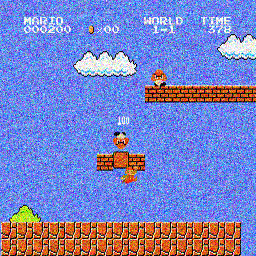

In [17]:
PIL.Image.fromarray(np.uint8(noisy_model_input.numpy() * 255.))